# 설정

In [7]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "KNN"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# k-최근접 이웃: 게으른 학습 알고리즘

이 장에서는 <b>k-최근접 이웃</b><sup>K-Nearest Neighbor, KNN</sup>을 소개한다. 이 알고리즘은 지금까지 설명했던 학습 알고리즘과는 근본적으로 다르다. KNN은 전형적인 <b>게으른 학습기</b><sup>lazy learner</sup>다. 단순하기에 게으르다고 말하는 것이 아니라 알고리즘이 훈련 데이터에서 판별 함수<sup>discriminative function</sup>를 학습하는 대신 훈련 데이터셋을 메모리에 저장하기 때문이다.

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> <b>모수 모델 vs 비모수 모델</b><br><br>
    머신 러닝 알고리즘은 <b>모수 모델</b><sup>parametric model</sup>과 <b>비모수 모델</b><sup>nonparametric model</sup>로 묶을 수 있다. 모수 모델은 새로운 데이터 포인트를 분류할 수 있는 함수를 학습하기 위해 훈련 데이터셋에서 최적의 모델 파라미터를 추정한다. 훈련이 끝나면 원본 훈련 데이터셋이 더 이상 필요하지 않다. 전형적인 모수 모델은 퍼셉트론, 로지스틱 회귀, 선형 SVM이다. 반대로 비모수 모델은 고정된 개수의 파라미터로 설명될 수 없다. 훈련 데이터가 늘어남에 따라 파라미터 개수도 늘어난다. 지금까지 본 모델 중 비모수 모델 두 개는 결정 트리/랜덤 포레스트와 커널 SVM이다.<sup><a id="a01" href="#p01">[1]</a></sup><br><br>
    KNN은 비모수 모델에 속하며 인스턴스 기반 모델이라고 한다. 인스턴스 기반 모델은 훈련 데이터셋을 메모리에 저장하는 것이 특징이다. 게으른 학습은 인스턴스 기반 학습의 특별한 경우이며 학습 과정에 비용이 전혀 들지 않는다.
    </div>

다음은 KNN의 추가적인 특성이다.

<ul>
    <li>데이터를 하나씩 순차적으로 학습한다.</li>
    <li>기본적으로 모든 데이터와의 거리를 계산해야 하므로 예측에 시간이 걸린다.</li>
    <li>$k$값에 따라 편차는 있지만 예측 성능은 괜찮은 편이다.</li>
</ul>

KNN 분류 알고리즘은 매우 간단해서 다음 단계로 요약할 수 있다.

<ol>
    <li>숫자 $k$와 거리 측정 기준을 선택한다.</li>
    <li>분류하려는 샘플에서 $k$개의 최근접 이웃을 찾는다.</li>
    <li>다수결 투표를 통해 클래스 레이블을 할당한다.</li>
</ol>

KNN 예측 알고리즘은 다음 단계로 요약할 수 있다.

<ol>
    <li>숫자 $k$와 거리 측정 기준을 선택한다.</li>
    <li>예측하려는 샘플에서 $k$개의 최근접 이웃을 찾는다.</li>
    <li>탐색된 $k$개 학습 데이터의 평균을 예측 값으로 할당한다.</li>
</ol>

[그림 1]는 새로운 데이터 포인트(물음표로 표시된 포인트)가 어떻게 이웃 다섯 개의 다수결 투표를 기반으로 삼각형 클래스 레이블에 할당되는지 보여 준다.

<b>그림 1</b> k-최근접 이웃의 다수결 투표
<div style="text-align:center;">
    <img src="./images/KNN/k-최근접 이웃의 다수결 투표.jpg">
</div>

선택한 거리 측정 기준에 따라서 KNN 알고리즘이 훈련 데이터셋에서 분류하려는 포인트와 가까운 (가장 비슷한) 샘플 $k$개를 찾는다. 새로운 데이터 포인트의 클래스 레이블은 이 $k$개의 최근접 이웃에서 다수결 투표를 하여 결정된다.

이런 메모리 기반 방식의 분류기는 수집된 새로운 훈련 데이터에 즉시 적응할 수 있는 것이 주요 장점이다. 새로운 샘플을 분류하는 계산 복잡도는 단점이다. 데이터셋의 차원(특성)이 적고 알고리즘이 KD-트리 같은 효율적인 데이터 구조로 구현되어 있지 않다면 최악의 경우 훈련 데이터셋의 샘플 개수에 선형적으로 증가한다.<sup><a id="a02" href="#p02">[2]</a></sup> 또 훈련 단계가 없기 때문에 훈련 샘플을 버릴 수 없다. 대규모 데이터셋에서 작업한다면 저장 공간에 문제가 생긴다.

다음 코드를 실행하면 유클리디안<sup>euclidean</sup> 거리 측정 방식을 사용한 사이킷런의 KNN 모델을 만든다.

C:\Users\Sangjin\AppData\Local\Temp\ipykernel_26736\3988714383.py:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


그림 저장: knn_plot


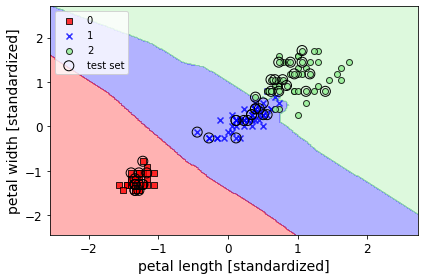

In [8]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5,
                           p=2,
                           metric='minkowski')
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=knn, test_idx=range(105, 150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
save_fig('knn_plot')
plt.show()

KNN 모델에 다섯 개의 이웃을 지정했으므로 이 데이터셋에서 위 그림과 같이 비교적 부드러운 결정 경계를 얻었다.

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> 다수결 투표가 동일할 경우 사이킷런의 KNN 구현은 샘플에 더 가까운 이웃을 예측으로 선택한다. 이웃들의 거리가 같다면 훈련 데이터셋에서 먼저 나타난 샘플의 클래스 레이블을 선택한다.
    </div>

## 하이퍼 파라미터

앞서 언급했지만 KNN의 하이퍼 파라미터에는 두 가지 종류가 있다.
<ol>
    <li>$k$: 인접한 학습 데이터를 몇 개까지 탐색할 것인가?</li>
    <li><b>Distance Measures</b>: 데이터 간 거리는 어떻게 측정할 것인가?</li>
</ol>

### k

적절한 $k$를 선택하는 것은 과대적합과 과소적합 사이에서 올바른 균형을 잡기 위해 중요하다.

$k$가 매우 작은 경우, 데이터의 지역적 특성을 지나치게 반영하여 과대적합의 위험이 있다. 반대로, $k$가 매우 큰 경우에는 다른 범주의 개체를 너무 많이 포함하여 오분류할 위험이 커지는 과소적합의 위험이 있다.

따라서 일정 범위 내로 $k$를 조정하여 (1 ~ $k^*$), 가장 좋은 예측 결과를 보이는 $k$값을 선정한다.

<b>분류모델 식</b>
$$
\mathrm{Misclass\,\,Error_k} = \frac{1}{k}\sum_{i=1}^kI(c_i≠\hat{c}_i)\\
for\,\, k = 1, 2, ..., k^*\\
I(\cdot) = Indicator Function\begin{cases}
1 & \text{ if } \mathrm{True}\\
0 & \text{ if } \mathrm{False}
\end{cases}
$$

<b>예측모델 식</b>
$$
\mathrm{SSE}_k = \sum_{i=1}^k(y_i - \hat{y}_i)^2\\
for\,\, k = 1, 2, ..., k^*
$$

위 식을 가장 작게 만드는 $k^*$값을 선정한다.

### Distance Measures

데이터셋의 특성에 알맞은 거리 측정 지표를 선택해야 한다. 여기서 거리 측정 지표는 1 - 유사도로 가까울수록 작은 값을, 멀 수록 큰 값을 갖는다. 다음은 대표적인 거리 측정 지표다.

<ul>
    <li>Euclidean Distance</li>
    <li>Manhattan Distance</li>
    <li>Mahalanobis Distance</li>
    <li>Correlation Distance
        <ul>
            <li>Pearson Correlation</li>
            <li>Spearman Rank Correlation</li>
        </ul>
    </li>
</ul>

데이터 내 변수들이 각기 다른 데이터 범위, 분산 등을 가질 수 있으므로, 데이터 정규화(혹은 표준화)를 통해 이를 맞추는 것이 중요하다.

<b>Euclidean Distance</b>
$$
d_{\mathrm{Euclidean}}(X, Y) = \sqrt{\sum_{i=1}^n(x_i - y_i)^2}
$$

가장 흔히 사용하는 거리 측정 지표다. 대응되는 X, Y 값 간 차이 제곱합의 제곱근으로써 두 관측치 사이의 직선 거리(=최단 거리)를 의미한다.

<b>Manhattan Distance(Taxi cab Distance)</b>
$$
d_{\mathrm{Manhattan}}(X, Y) = \sum_{i=1}^n|x_i - y_i|
$$

X에서 Y로 이동 시 각 좌표 축 방향으로만 이동할 경우에 계산되는 거리로 같은 X와 Y에 대한 유클리디안 거리는 항상 크거나 같다(같은 경우는 X와 Y 좌표가 같을 때).

위 코드에서 사용한 minkowski 거리는 유클리디안 거리와 맨해튼 거리를 일반화한 것으로 다음과 같이 쓸 수 있다.

$$
d(X, Y) = \sqrt[p]{\sum_{i=1}^n|x_i - y_i| ^ p}
$$

매개변수 $p=2$로 지정하면 유클리디안 거리가 되고 $p=1$로 지정하면 맨해튼 거리가 된다.<sup><a id="a03" href="#p03">[3]</a></sup>

<b>Mahalanobis Distance</b>
$$
d_{\mathrm{Mahalanobis}}(X, Y) = \sqrt{(X - Y)^T\Sigma^{-1}(X-Y)}\\
\Sigma^{-1}: \text{inverse of covariance matrix}
$$

변수 내 분산, 변수 간 공분산을 모두 반영하여 X, Y간 거리를 계산하는 방식이다. 이때 데이터의 covariance matrix가 identity matrix인 경우는 유클리디안 거리와 동일하다.

$$
\sqrt{(X-Y)^T\Sigma^{-1}(X-Y)} = c\,(\text{c is Mahalanobis distance)}\\
\to (X-Y)^T\Sigma^{-1}(X-Y) = c^2
$$

$$
\mathrm{Let}\, X = \begin{pmatrix}
x_1 \\
x_2\end{pmatrix}, Y = \begin{pmatrix}
y_1 \\
y_2\end{pmatrix}, \Sigma^{-1} = \begin{pmatrix}
s_{11}^{-1} & s_{12}^{-1} \\
s_{21}^{-1} & s_{22}^{-1} \\
\end{pmatrix}, \mathrm{then}\\
\to (x_1 - y_1)^2s_{11}^{-1} + 2(x_1-y_1)(x_2-y_2)s_{12}^{-1} + (x_2 - y_2)s_{22}^{-1} = c^2 (\because s_{12}^{-1} = s_{21}^{-1})
$$

It can be considered as the squared Mahalanobis distance between a certain point X, and the fixed point Y.

$$
\mathrm{Let}\,Y = \begin{pmatrix}
0\\
0\\
\end{pmatrix}, then\\
\to x_1^2s_{11}^{-1} + 2x_1x_2s_{12}^{-1}+x_2^2s_{22}^{-1} = c^2
$$

which is a general equation of the ellipse.

즉, Mahalanobis distance의 제곱은 타원이라는 사실을 알 수 있다.

<b>Correlation Distance</b>
$$
d_{\text{corr}}(X, Y) = 1 - r\\
\mathrm{where}\,\, r = \sigma_{XY}
$$

데이터 간 Pearson correlation을 거리 측정 지표로 사용하는 방식으로, 데이터 패턴의 유사도를 반영할 수 있다. 범위는 $0≤d_{\text{corr}}≤2$이다.

<b>Spearman Rank Correlation Distance</b>
$$
d_{\text{spearman}}(X, Y) = 1 - \rho\\
\mathrm{where}\,\, \rho = 1 - \frac{6\sum_{i=1}^n(\mathrm{rank}(x_i)-\mathrm{rank}(y_i))^2}{n(n^2-1)}
$$

$\rho$를 Spearman correlation 이라고 하며, 이는 데이터의 rank를 이용하여 correlation distance를 계산하는 방식이다. $\rho$의 범위는 -1부터 1로, Pearson correlation과 동일하다.

# Weighted KNN

KNN 예측 알고리즘에서는 해당 샘플 주변 $k$개 샘플의 평균을 할당했으며, 분류 알고리즘에서는 다수결 투표를 통해 클래스를 할당했다. 하지만, 거리에 따라 가중치를 주는 좀 더 정확한 모델을 구축할 수도 있다.

즉, 새 데이터와 기존 학습 관측치 간의 거리를 가중치로 하여 예측 결과를 도출한다.

<b>Weighted KNN 예측 모델 식</b>
$$
\hat{y}_{\text{new}} = \frac{\sum_{i=1}^kw_iy_i}{\sum_{i=1}^kw_i}\\
\text{where}\,\, w_i = \frac{1}{d(x_\text{new}, x_i)}
$$

<b>Weighted KNN 분류 모델 식</b>
$$
\hat{c}_\text{new} = \underset{c}{\mathrm{max}}\sum_{i=1}^kw_iI(w_i\in c)\\
\text{where}\,\, w_i = \frac{1}{d(x_\text{new}, x_i)}
$$

# 정리

<b>장점</b>
<ul>
    <li>데이터 내 노이즈에 영향을 크게 받지 않으며, 특히 Mahalanobis distance와 같이 데이터의 분산을 고려할 경우 강건<sup>robust</sup>하다.</li>
    <li>학습 데이터의 수가 많을 경우 효과적이다.</li>
</ul>

<b>한계점</b>
<ul>
    <li>파라미터 $k$의 값을 선택해야 한다.</li>
    <li>어떤 거리 척도가 분석에 적합한지 불분명해서 데이터의 특성에 맞는 거리 측정 지표를 임의로 선정해야 한다.</li>
    <li>새로운 관측치와 각각의 학습 데이터 간 거리를 전부 측정해야 하므로, 계산 시간이 오래 걸린다.</li>
    <li>고차원일 경우 거리가 불분명하여 성능이 떨어진다.</li>
</ul>

# 그림을 위한 코드

In [1]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

print('클래스 레이블:', np.unique(y))

클래스 레이블: [0 1 2]


In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [3]:
print('y의 레이블 카운트:', np.bincount(y))
print('y_train의 레이블 카운트:', np.bincount(y_train))
print('y_test의 레이블 카운트:', np.bincount(y_test))

y의 레이블 카운트: [50 50 50]
y_train의 레이블 카운트: [35 35 35]
y_test의 레이블 카운트: [15 15 15]


In [4]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [5]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    
    # 마커와 컬러맵을 설정한다
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 결정 경계를 그린다
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor='black')
        
    # 테스트 샘플을 부각하여 그린다
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        
        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    facecolors='none',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100,
                    label='test set')

In [6]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

# 미주

<b id="p01">1</b> 결정 트리는 분할을 위한 노드가 늘어나고 커널 SVM은 쌍대 형식을 풀기 위한 커널 함수 계산이 늘어난다. [↩](#a01)

<b id="p02">2</b> An Algorithm for Finding Best Matches in Logarithmic Expected Time, J, H. Friedman, J.L.Bentley, and R.A.Finkel, ACM transactions on mathematical software (TOMS), 3(3): 209-226, 1977 [↩](#a02)

<b id="p03">3</b> KNeighborsClassifier 클래스의 metric 매개변수의 기본값이 'minkowski'이고 p의 기본값은 2다. algorithm 매개변수의 기본값은 'auto'로 minkowski 거리를 사용하면 KD-트리 알고리즘이 된다. knn 객체의 \_fit_method 속성에서 사용된 알고리즘을 확인할 수 있다. [↩](#a03)